In [1]:
# jupyter nbconvert --to html --template lab --output dataset_analysis.html dataset_analysis.ipynb --no-input

## Reading the dataset

In [2]:
import os
import pandas as pd
import cv2
import yaml
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import IFrame

pd.options.display.max_colwidth = 1000

dataset_path = "/home/anna/Datasets/annotated"
subdatasets = next(os.walk(dataset_path))[1]
subdatasets.remove("warp_matrices")
subdatasets.remove("warp_matrices_with_panchrom")

data = []
columns = ["subdataset", "image_path", "annot_path", "width",  "height", "altitude", "hour", "annots"] 


for subdataset in subdatasets:
    subdataset_path = os.path.join(dataset_path, subdataset)
    for image in os.listdir(os.path.join(subdataset_path, "images", "train")):
        if image.endswith("ch0.tiff"): # only one image per group
            image_path = os.path.join(subdataset_path, "images", "train", image)
            annot_path = os.path.join(subdataset_path, "labels", "train", image.replace(".tiff", ".txt"))

            altitude = f"{round(float(image.split('_')[-2])/5)*5:2d}" # rounded to 5 meters
            hour = int(image.split('_')[1])
            
            with open(os.path.join(subdataset_path, "data_config.yaml"), "r") as file:
                config = yaml.safe_load(file)
                class_names = config["names"]

            image = cv2.imread(image_path)
            h, w = image.shape[:2]

            annots = []
            with open(annot_path, "r") as f:
                for line in f:
                    class_id, center_x, center_y, width, height = map(float, line.split())
                    class_name = class_names[int(class_id)]

                    object_width = width * w
                    object_height = height * h

                    annots.append([class_name, object_width, object_height])          

            data.append([subdataset, image_path, annot_path, h, w, altitude, hour, annots])
        
    
df = pd.DataFrame(columns=columns, data=data)


## Images

Let's firstly check how many photos do we have in each subdataset. And what are their dimensions.

In [3]:
subdatasets

['ghost-net', 'black-bed', 'bags', 'pile', 'green-net', 'mandrac', 'mandrac2']

In [4]:
df.head(1)

,subdataset,image_path,annot_path,width,height,altitude,hour,annots
0,ghost-net,/home/anna/Datasets/annotated/ghost-net/images/train/ghost-net_15_0006_15_ch0.tiff,/home/anna/Datasets/annotated/ghost-net/labels/train/ghost-net_15_0006_15_ch0.txt,1897,2447,15,15,"[[flake_PE_black, 13.999287, 14.999579000000002], [flake_PE_black, 7.0008669999999995, 8.999368], [flake_PE_black, 15.00011, 13.000141], [flake_PE_black, 6.000044000000001, 6.99993], [bag_PE_white, 81.00059399999999, 82.999441], [flake_PE_black, 9.000066, 8.999368], [buoy_PS_white, 22.999353, 19.000352], [flake_PE_black, 16.999309, 15.999298000000001], [flake_PE_black, 19.000955, 19.000352], [flake_PE_black, 16.000933, 14.999579000000002], [bag_PE_white, 55.001219, 80.00028400000001], [flake_PE_black, 16.000933, 17.000913999999998], [wood_wood_brown, 22.999353, 67.00014300000001], [bag_PE_white, 69.000506, 87.000214], [bag_PE_red, 64.999661, 61.99965099999999], [styrofoam_PS_black, 49.999551, 42.999299], [bottle_PET_orange, 15.00011, 14.999579000000002], [bottle_PET_transparent, 42.000308, 35.999369], [bag_PE_transparent, 63.000462000000006, 49.999229], [bag_PE_transparent, 49.999551, 63.999089000000005], [bag_PE_yellow, 72.000528, 72.000635], [flake_PE_black, 10.000889, 12.000422]..."


In [5]:
counts = df["subdataset"].value_counts()
counts.name = "number of images"

print("number of images per subdataset\n")
print(counts)
print(f"\nin total {counts.sum()} images (with 5 channels)")


number of images per subdataset

subdataset
mandrac2     78
ghost-net    49
mandrac      37
bags         22
black-bed    12
green-net     5
pile          4
Name: number of images, dtype: int64

in total 207 images (with 5 channels)


In [6]:
print("Statistics of the images' dimensions")
df[["width", "height"]].describe()

Statistics of the images' dimensions


,width,height
count,207.000000,207.000000
mean,1572.748792,2060.531401
std,419.270257,498.211488
min,1034.000000,1419.000000
25%,1035.000000,1422.000000
50%,1895.000000,2447.000000
75%,1897.000000,2447.000000
max,1903.000000,2447.000000


After merging the channels height is the same for all images aligned with the same warp matrices. Width varies, but not much (8 px).

Mandrac2 dataset was aligned with new matrices (without panchromatic channel), so it has different dimensions (1920x1035 instead of 2447x1895)

<div style="display:flex; justify-content:center; gap:2%;">

  <figure style="text-align:center; width:45%;">
    <img src="/home/anna/code/multispectral/out/bags_9_0004_30_RGB.png" width="100%" />
    <figcaption>Joined with old warp matrices</figcaption>
  </figure>

  <figure style="text-align:center; width:45%;">
    <img src="/home/anna/code/multispectral/out/bags_9_new_warp/0004_30/0004_30_RGB.png" width="100%" />
    <figcaption>Joined with new warp matrices</figcaption>
  </figure>

</div>

It seems with the new warp matrices we get wider horizontal field of view.

## Classes

We have 28 classes in our data, but some of them has only a few annotations.

In [7]:
def add_numbers_to_hist(ax):
    # Dodanie liczb nad słupkami
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=10, color='black', 
                    xytext=(0, 5), textcoords='offset points')

In [29]:
df["classes"] = df["annots"].map(lambda x: [class_id for class_id, _, _ in x])

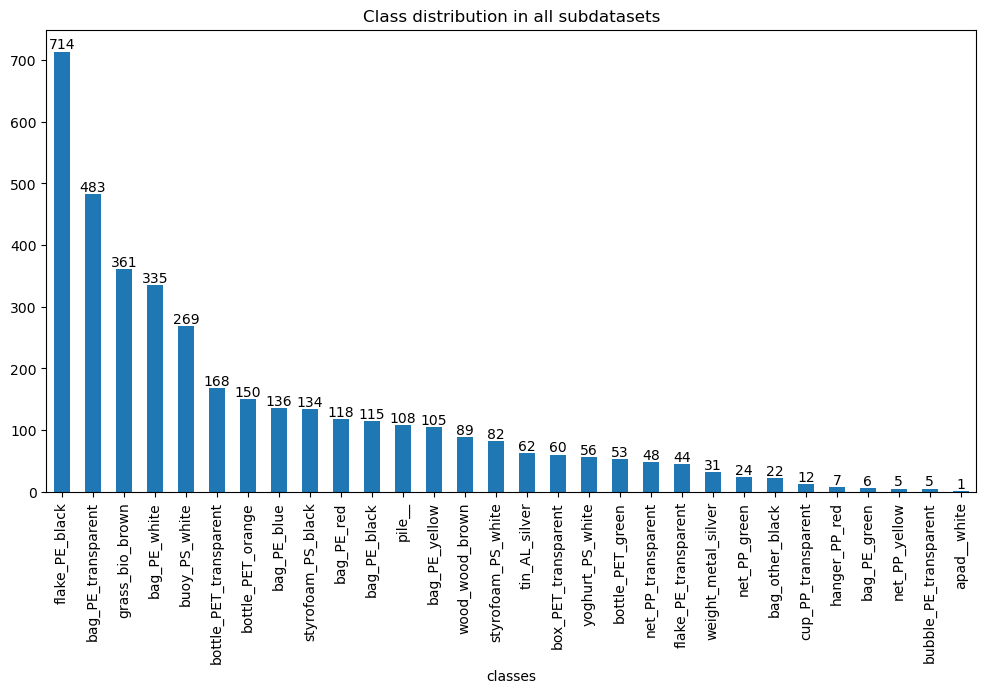

In [33]:
classes = df["classes"].explode()
classes = classes.str.replace(r'pile\b', 'pile__', regex=True)
plt.figure(figsize=(12, 6))
ax = classes.value_counts().plot(kind="bar")
add_numbers_to_hist(ax)

plt.xticks(rotation=90)
plt.title("Class distribution in all subdatasets")

plt.show()

The APAD was included in one image by mistake.

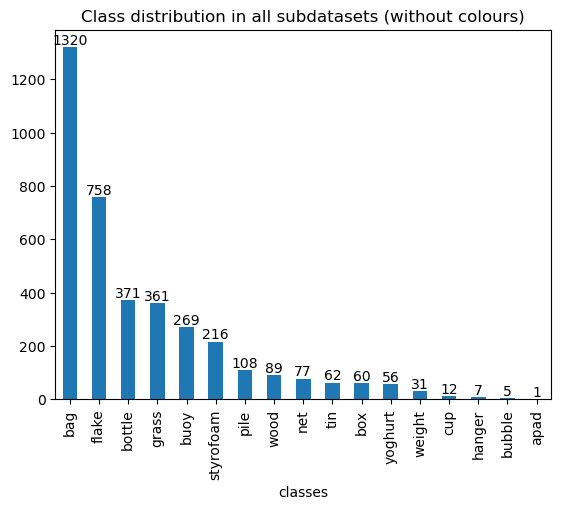

In [34]:
ax = classes.map(lambda name: name.split("_")[0]).value_counts().plot(kind="bar")
add_numbers_to_hist(ax)
plt.title("Class distribution in all subdatasets (without colours)")
plt.show()

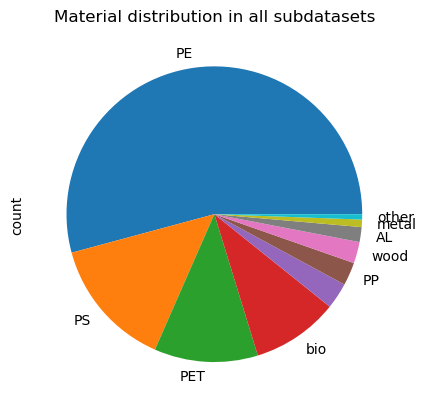

In [35]:
classes.map(lambda name: name.split("_")[1]).value_counts().plot(kind="pie")

plt.title("Material distribution in all subdatasets")
plt.show()

Empty material stands for APAD and pile.

The classes are highly unbalanced. We'll have to think about joining the minority classes together.

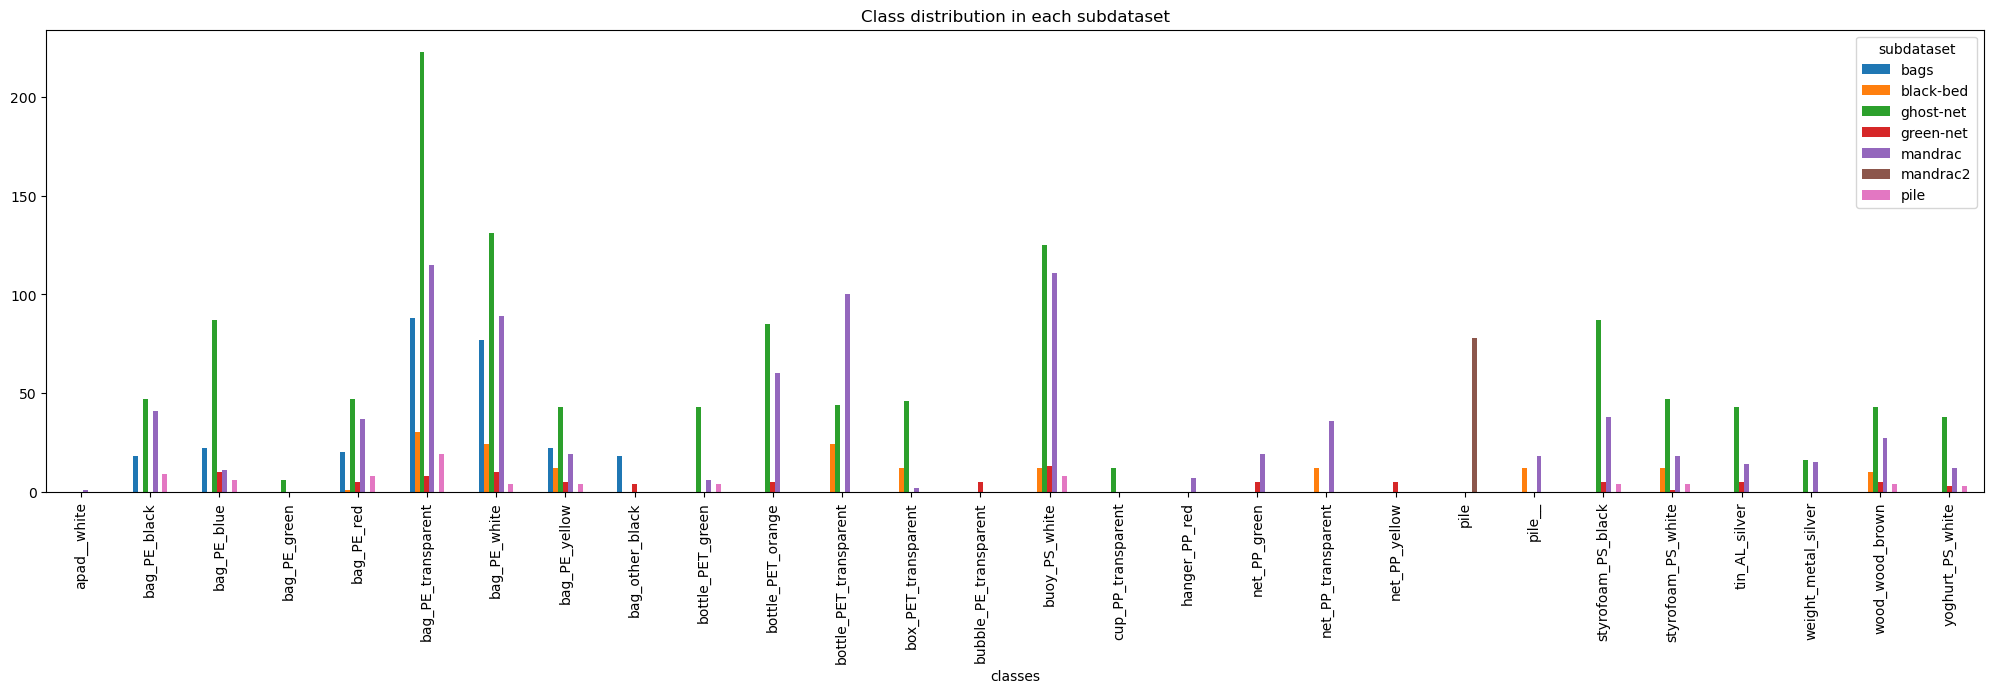

In [36]:
filtered_classes = ["grass_bio_brown", "flake_PE_black", "flake_PE_transparent"]
# filtered_classes = []

subdataset_classes = df[["subdataset", "classes"]].groupby("subdataset").agg(lambda x: x.sum())
subdataset_classes_filter = ~(subdataset_classes.explode("classes").reset_index()["classes"].isin(filtered_classes))

fig, ax = plt.subplots(figsize=(25, 6))
subdataset_classes.explode("classes").reset_index()[subdataset_classes_filter].groupby(["classes","subdataset"]).size().unstack().plot(kind="bar", ax=ax)
plt.title("Class distribution in each subdataset")
plt.show()

As flakes were used in one two experiments, and currently we don't aim for detecting them in our system, we can eliminate them. Also, the grass was not marked on all images, so we can't use it. 

As we can see the number of items from each class highly varies between the subdatasets. Also, some datasets have much more images than the others. We have to consider this when splitting the data.

## Litter size

In [37]:
df["widths"] = df["annots"].map(lambda x: [w for _, w, _ in x])
df["heights"] = df["annots"].map(lambda x: [h for _, _, h in x])

print("Statistics of the litter width and height in px\n")
print(df["widths"].explode().astype(float).describe(), "\n")
print(df["heights"].explode().astype(float).describe())

Statistics of the litter width and height in px

count    3803.000000
mean       53.596207
std        99.265977
min         1.000823
25%        15.000110
50%        28.999397
75%        57.499606
max      2329.999142
Name: widths, dtype: float64 

count    3803.000000
mean       52.760209
std        95.063771
min         0.999719
25%        14.999579
50%        28.000742
75%        57.999634
max      1903.000000
Name: heights, dtype: float64


In [38]:
trash_df = df[["widths", "heights", "classes", "altitude"]].explode(["widths", "heights", "classes"], ignore_index=True).sort_values("altitude")
trash_df["widths"] = trash_df["widths"].astype(float)
trash_df["heights"] = trash_df["heights"].astype(float)
trash_df["trash_type"] = trash_df["classes"].map(lambda name: name.split("_")[0])

In [39]:
fig = px.scatter(
    trash_df, 
    x="widths", 
    y="heights", 
    color="trash_type", 
    hover_data=["classes"],  # Show class name on hover
    title="Widths and heights of the litter",
    labels={"widths": "Widths", "heights": "Heights"},
    width=1000,
    height=800
)

# fig.show()
# fig.write_html("litter_dims.html")
IFrame("img/litter_dims.html", width=fig.layout.width or 1000, height=fig.layout.height or 800)

In [40]:
fig = px.scatter(
    trash_df[(trash_df["widths"] < 50) & (trash_df["heights"] < 50)],
    x="widths", 
    y="heights", 
    color="trash_type", 
    hover_data=["classes"],  # Show class name on hover
    title="Widths and heights of objects smaller than 50x50 pixels",
    labels={"widths": "Widths", "heights": "Heights"},
    width=1000,
    height=800
)

# fig.show()

# fig.write_html("litter_dims_50x50.html")
IFrame("img/litter_dims_50x50.html", width=fig.layout.width or 1000, height=fig.layout.height or 800)

As we can see in our dataset we have a lot of object smaller than 50x50 pixels. The smallest bag is probably a mistake in annotations, but we have objects even with 9px sizes. To properly train YOLO, the object should be at least 16x16 pixels (https://www.ccoderun.ca/programming/yolo_faq/#optimal_network_size). I'll from now treat it as a treshold from which the objects are not visible. It means we cannot resize the images, because even now some objects might be not seen.

Moreover, to feed the image to YOLO, both dimensions should be multiples of 32. As I've said before, the average image size is 1898 x 2447 px. None of them is a multiple of 32. Instead we can use a size of 1888 x 2432. It means we'll resize each dimension by approximately a factor of 0.994, which doesn't make much change.

However, this is a huge image to feed to NN. Originally YOLO accepts images 640 x 640 px, which is almost 4 times smaller.

Let's see if we can detect something if we'd make the image 4 times smaller.

In [41]:
fig = px.scatter(
    trash_df,
    x="widths", 
    y="heights", 
    color="altitude", 
    color_discrete_sequence = ['blue', 'purple', 'magenta', 'red', 'orange', 'yellow'],
    hover_name="classes", 
    title="Widths and heights by altitude",
    labels={"widths": "Widths", "heights": "Heights"},
    width=1000,
    height=800
)

# fig.show()

# fig.write_html("litter_dims_alt.html")
IFrame("img/litter_dims_alt.html", width=fig.layout.width or 1000, height=fig.layout.height or 800)

In [42]:
filtered_classes = ["flake", "grass"]

fig = px.scatter(
    trash_df[(trash_df["widths"] < 50) & (trash_df["heights"] < 50) & ~(trash_df["trash_type"].isin(filtered_classes))],
    x="widths", 
    y="heights", 
    color="altitude", 
    color_discrete_sequence = ['blue', 'purple', 'magenta', 'red', 'orange', 'yellow'],
    hover_name="classes", 
    title="Widths and heights by altitude for litter smaller than 50x50",
    labels={"widths": "Widths", "heights": "Heights"},
    width=1000,
    height=800,
)

# fig.show()

# fig.write_html("litter_dims_alt_50x50.html")
IFrame("img/litter_dims_alt_50x50.html", width=fig.layout.width or 1000, height=fig.layout.height or 800)

In [43]:
print("Litter dimensions by altitude")
trash_df["mean_dim"] = (trash_df["widths"] * trash_df["heights"])**0.5 # geometric mean
trash_df.groupby("altitude")[["altitude", "mean_dim"]].describe().reset_index()

Litter dimensions by altitude


altitude mean_dim                                                           \
              count        mean         std        min        25%        50%   
0        5    638.0  110.492886  157.572040  10.816604  37.868293  80.436222   
1       10    791.0   62.095507   97.506792   6.928618  23.494511  41.892688   
2       15    726.0   39.653881   65.076083   1.000271  14.865847  24.328434   
3       20    677.0   30.852508   49.021792   2.999747  10.999928  20.198418   
4       25    449.0   29.085870   43.724227   2.999903  11.832795  20.000078   
5       30    522.0   29.779720   44.073417   2.827983  11.488330  18.774400   

                            
          75%          max  
0  151.274324  2102.086061  
1   76.272410  1120.447801  
2   48.775169   809.344937  
3   38.961937   627.881830  
4   33.166550   487.070557  
5   32.350024   383.515192

For the altitude 30 most of the litter is smaller than 30x30 pixels, which means if we reduce the size of the image even 2 times (to 944 x 1216, which is still very large image) we probably won't see any of our labeled objects. 

If we'd like to be able to detect most of the litter and make the images 3-4 times smaller, we'd have to fly on 5-10 meters, which is rather not satisfactory.


In [44]:
fig = px.scatter(
    trash_df[trash_df["trash_type"].isin(["pile"])],
    x="widths", 
    y="heights", 
    color="altitude", 
    color_discrete_sequence = ['blue', 'purple', 'magenta', 'red', 'orange', 'yellow'],
    hover_name="classes", 
    title="Pile sizes by altitude",
    labels={"widths": "Widths", "heights": "Heights"},
    width=1000,
    height=800
)

# fig.show()

# fig.write_html("pile_dims.html")
IFrame("img/pile_dims.html", width=fig.layout.width or 1000, height=fig.layout.height or 800)

However, if we wanted to detect the pile only, we could probably decrease the image size 5 times and the objects to detect will still be bigger than 16 px. But we have to keep in mind that we didn't annotate data for this. The piles are only marked for two subdatasets, and we're not even sure if they're marked on each photo.

We can also try training the network on the dataset we have without reducing image sizes and see how it performs. We can expect it'll have much longer train and inference times. To decrease it we can downsize the images, but then accuracy will probably drop, especially for the litter on higher altitudes.

## Splits

For the train-val-test split we should consider not only the class distribution, which we've already seen is highly unbalanced, but also the diversity of the subdatasets.

They were taken in different times of the day, weather conditions, with different background and different piles, some in the pool and some in the sea. It’s not trivial to determine train and test splits for the dataset. Below are 3 possible combinations allowing us to check different conditions which can influence the detection.

![splits](<img/Zrzut ekranu z 2025-02-12 14-19-50.png>)

I'll analyse them further below.


In [45]:
def class_hist(train_classes, test_classes, title):
    class_counts = pd.DataFrame({"Train": train_classes, "Test": test_classes}).fillna(0)

    class_counts.plot(kind="bar", figsize=(12, 6))
    plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel("")
    plt.legend(title="Split")
    # add_numbers_to_hist(plt.gca())

    plt.show()

def train_test_summary(train, test, df):
    n_train = len(df.iloc[train])
    n_test = len(df.iloc[test])
    n_total = n_train + n_test

    print(f"Train set ({n_train} images, {n_train/n_total * 100:.0f}%)\n")
    print(df.iloc[train].groupby("subdataset")["hour"].value_counts())

    print(f"\nTest set ({n_test} images, {n_test/n_total * 100:.0f}%)\n")
    print(df.iloc[test].groupby("subdataset")["hour"].value_counts())

    train_classes = df.iloc[train]["classes"].explode().value_counts()
    test_classes = df.iloc[test]["classes"].explode().value_counts()

    class_hist(train_classes, test_classes, "Number of objects per class")
    class_hist(train_classes/n_train, test_classes/n_test, "Mean number of objects per image")

### Robustness for different time and weather conditions

In this split we're taking only images obtained from the pool to compare robustness for different time and weather conditions. We're taking all the images taken at 3 p.m. to the test set and all the others to the train set.

Train set (65 images, 71%)

subdataset  hour
bags        12      10
            9        6
black-bed   11       6
ghost-net   12      27
            10       7
green-net   13       5
pile        14       4
Name: count, dtype: int64

Test set (27 images, 29%)

subdataset  hour
bags        15       6
black-bed   15       6
ghost-net   15      15
Name: count, dtype: int64


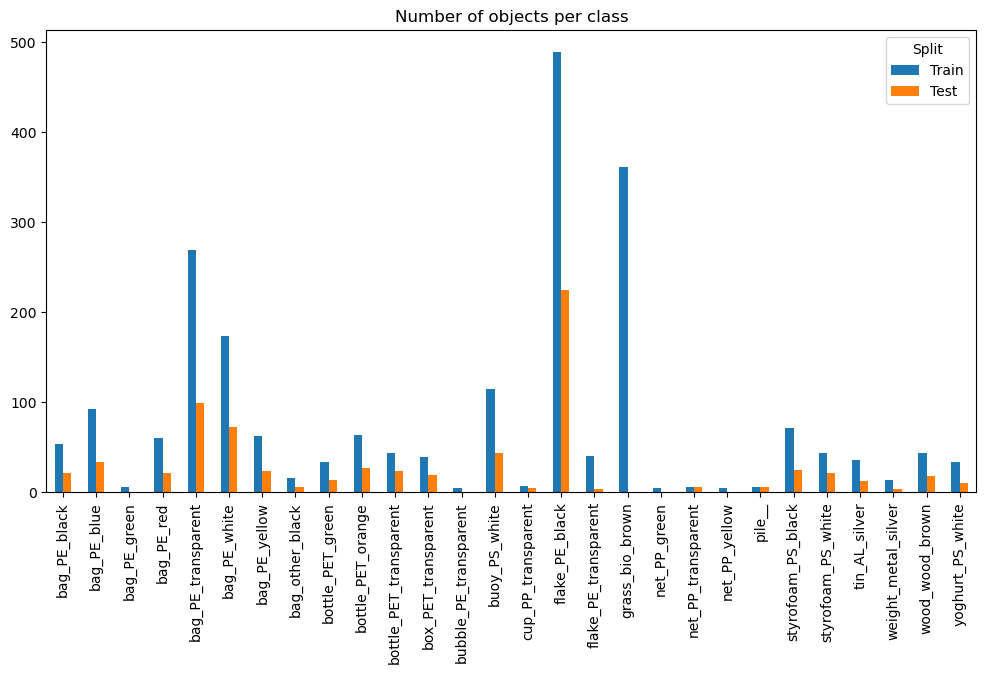

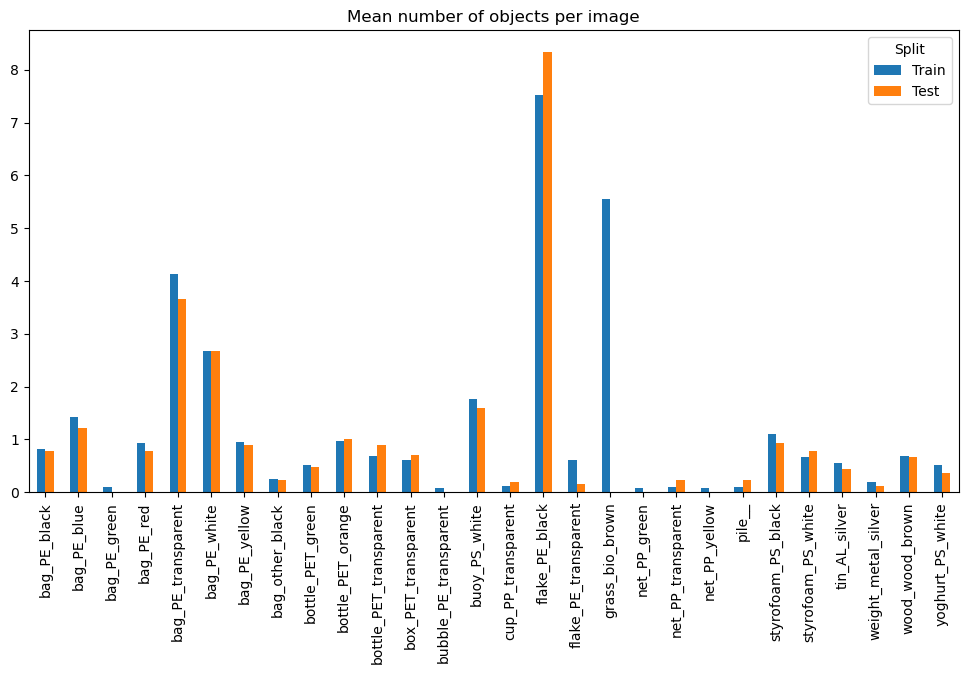

In [46]:
test = df[df["hour"] == 15].index
train = df[~df.index.isin(test) & ~df["subdataset"].str.contains("mandrac")].index

train_test_summary(train, test, df)


The classes are quite equally distributed between the train and test set, only the grass doesn't appear in the test set, but we've stated that we're not interested in predicting it. Also, some classes don't have enough examples, so we'll probably have to merge them.

### Train in pool test on the sea

Train set (92 images, 44%)

subdataset  hour
bags        12      10
            9        6
            15       6
black-bed   11       6
            15       6
ghost-net   12      27
            15      15
            10       7
green-net   13       5
pile        14       4
Name: count, dtype: int64

Test set (115 images, 56%)

subdataset  hour
mandrac     11      19
            10      11
            12       7
mandrac2    12      40
            11      38
Name: count, dtype: int64


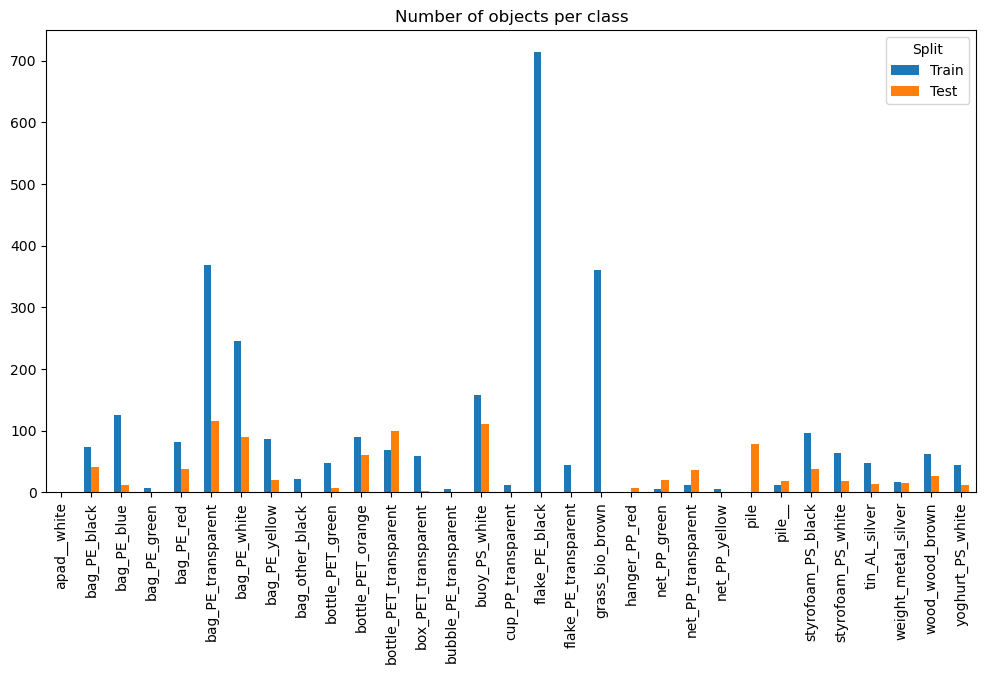

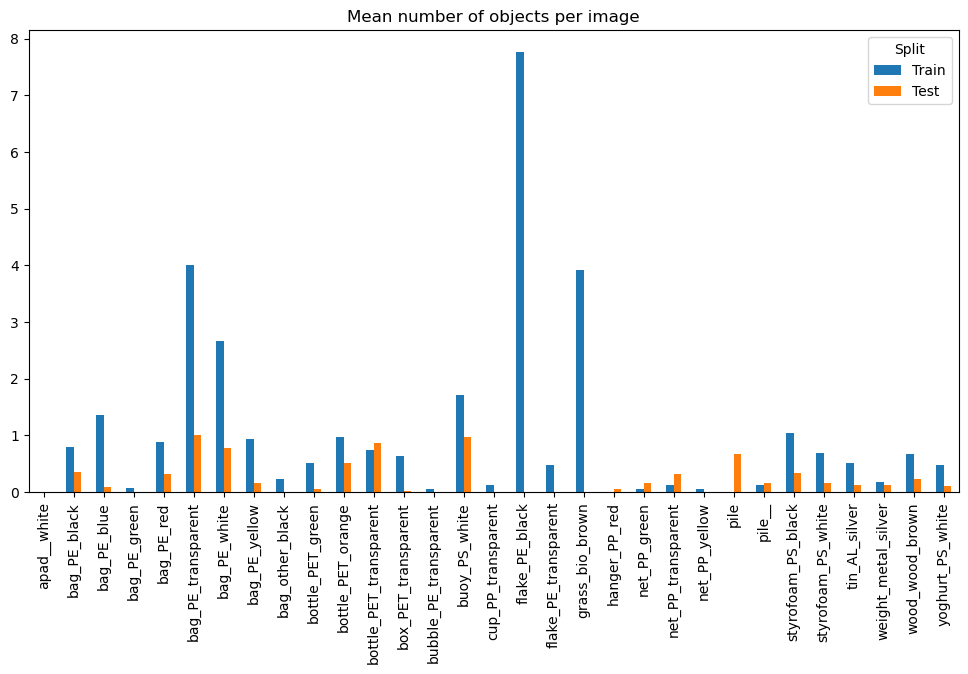

In [47]:
test = df[df["subdataset"].str.contains("mandrac")].index
train = df[~df.index.isin(test)].index

train_test_summary(train, test, df)

This split will show us how similar are the conditions in the pool and the sea. In this case, the class representation is a bit worse than in the previous one. In the pool we don't have so many annotations of the nets. Also, the transparent and orange bottles, and the buoys are more represented in the test set than in the train one. The possible class merge could not take the colours into consideration.

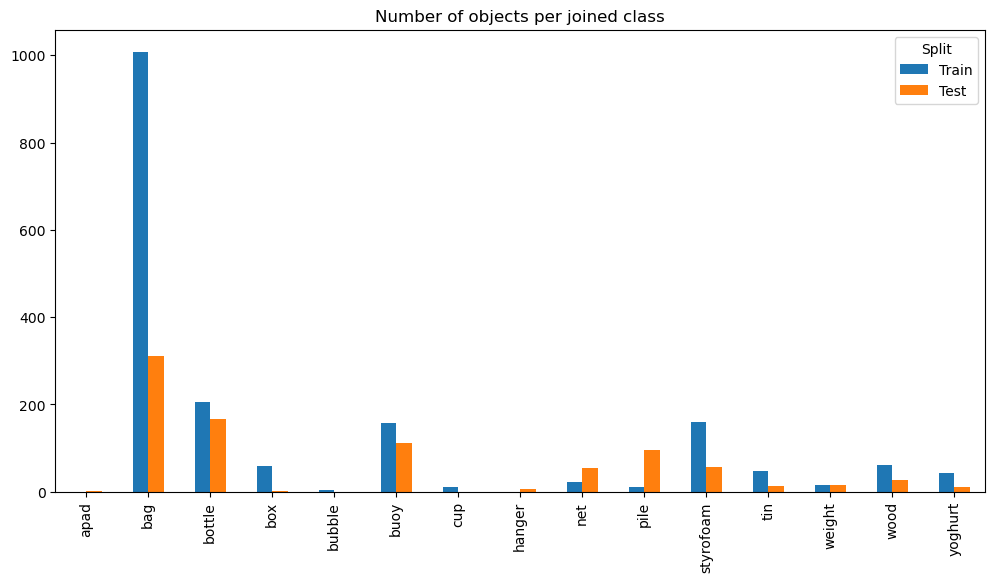

In [48]:
exclude = ["flake", "grass"]

def merge_classes(classes: list):
    return [n for name in classes if (n := name.split("_")[0]) not in exclude]


train_classes = df.iloc[train]["classes"].map(merge_classes).explode().value_counts()
test_classes = df.iloc[test]["classes"].map(merge_classes).explode().value_counts()

class_hist(train_classes, test_classes, "Number of objects per joined class")

For sure we still need to merge the minority classes and look on the annotations of whole pile in the pool subdatasets, if we need it, but the situation for bottles looks much better now. We can e.g. further merge buoys with styrofoam to represent those classes better.

### Different background and litter

In this split we're checking if the algorithm is able to generalise to new litter and background.

Ghost net, used in the training set is the most similar to other datasets. It uses the transparent net, as in black background and has a normal background as in green net, bags and pile. It means it is possible it can generalise to different background and different piles. Using pile and bags datasets for training can improve detecting smaller and different piles. Using the part of Mandrač dataset with the transparent net hopefully allows to capture the sea conditions. The class distribution is good enough to use it after merging the underrepresented classes.

Train set (171 images, 83%)

subdataset  hour
bags        12      10
            9        6
            15       6
ghost-net   12      27
            15      15
            10       7
mandrac     10      11
            12       7
mandrac2    12      40
            11      38
pile        14       4
Name: count, dtype: int64

Test set (36 images, 17%)

subdataset  hour
black-bed   11       6
            15       6
green-net   13       5
mandrac     11      19
Name: count, dtype: int64


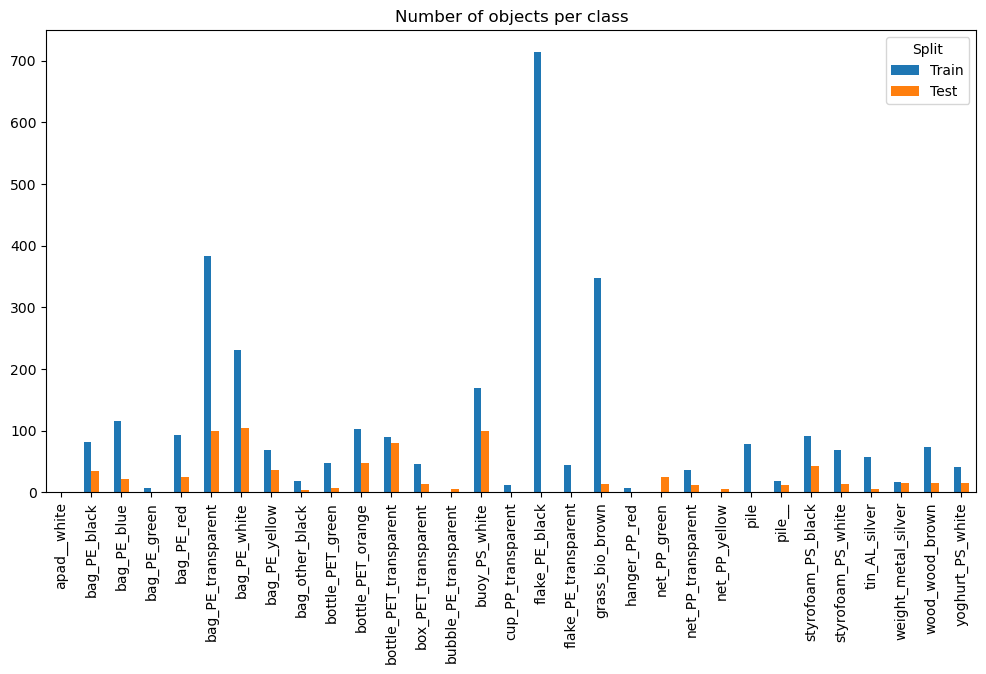

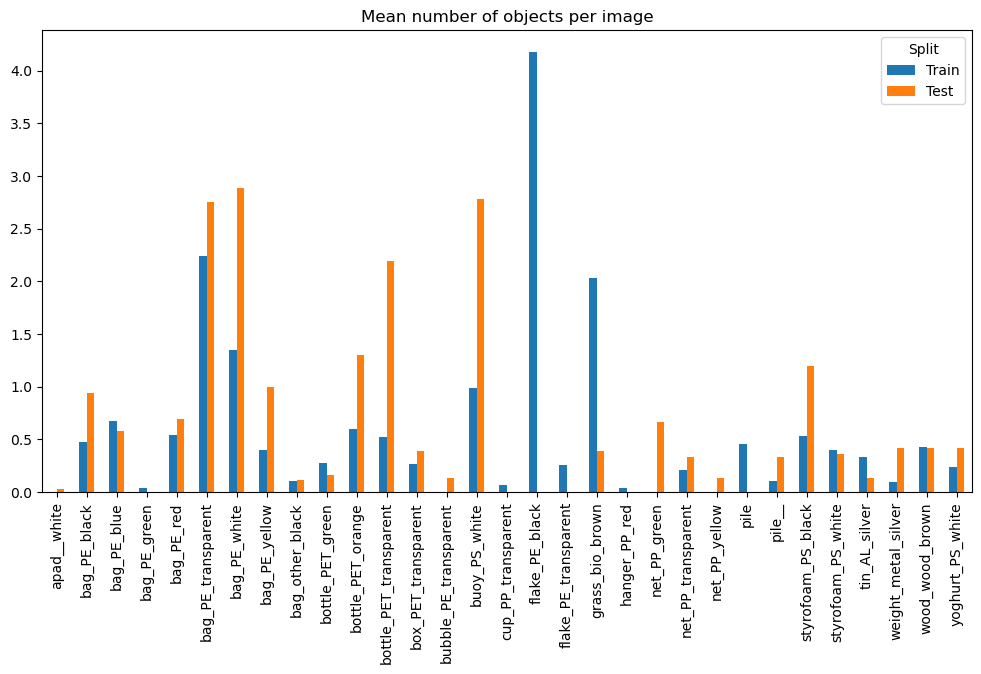

In [49]:
test = df[df["subdataset"].isin(["green-net", "black-bed"]) | df["image_path"].str.contains("green")].index
train = df[~df.index.isin(test)].index

train_test_summary(train, test, df)

Of course these are not all the possible combinations. We can check the different altitudes or just take 80% from each subdataset randomly, but we have to consider the final goal of our system. In particular now we have to think **how important is detecting each fraction of the litter and will the piles be enough**.